First task

Data import

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('newDataBaseVk.csv')
data = data.fillna(data.mean())
data = data.iloc[0:None, 1:10]
features = list(data.columns[:-1])
X = data[features]
data.head()

countFriends  countFollowers  boolComments  countOwnerPosts  \
0            75             137         False               11   
1           173             117         False                6   
2           324             549         False               20   
3           678              97         False                1   
4           398              38         False               14   

   countOwnerReposts  countPhotos  countVideos  countLikesPhotoes  sex  
0                  9            4           71                 14    2  
1                 14            9           26                234    1  
2                  0           40           64               1561    1  
3                 19           24          240               1111    2  
4                  6           11           12                480    1

PCA decomposition

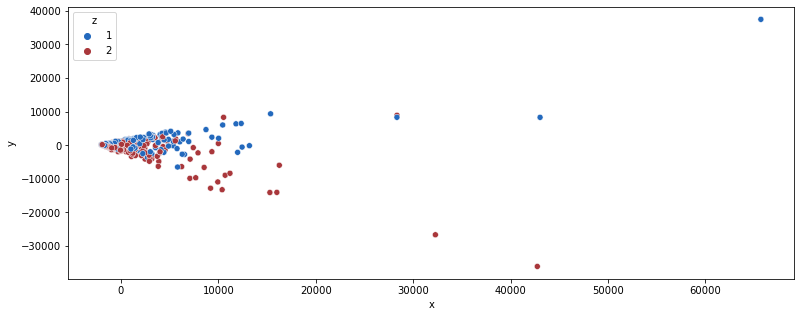

In [2]:
decomposed = PCA(n_components=2).fit_transform(X.values)

result = data.select_dtypes(include='int64').copy()
result['z'] = data['sex']
result['x'] = decomposed[:,0]
result['y'] = decomposed[:,1]

plt.figure(figsize=(13, 5))
sns.scatterplot(
    x="x", y="y",
    hue="z",
    data=result,
    legend="full",
    palette=sns.color_palette("vlag", as_cmap=True))

TSNE decomposition

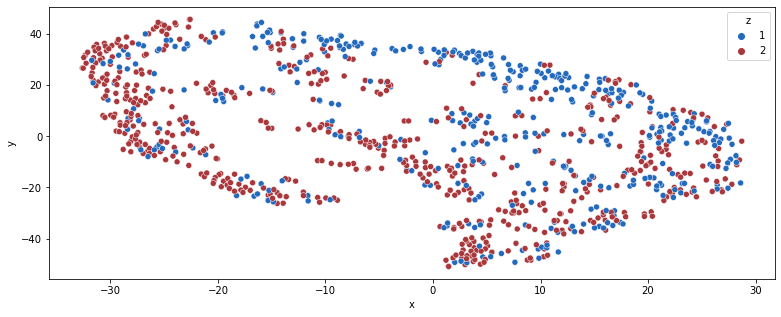

In [3]:
decomposed = TSNE(n_components=2).fit_transform(X.values)

result = data.select_dtypes(include='int64').copy()
result['z'] = data['sex']
result['x'] = decomposed[:,0]
result['y'] = decomposed[:,1]

plt.figure(figsize=(13, 5))
sns.scatterplot(
    x="x", y="y",
    hue="z",
    data=result,
    legend="full",
    palette=sns.color_palette("vlag", as_cmap=True))

Second task

Image quantization

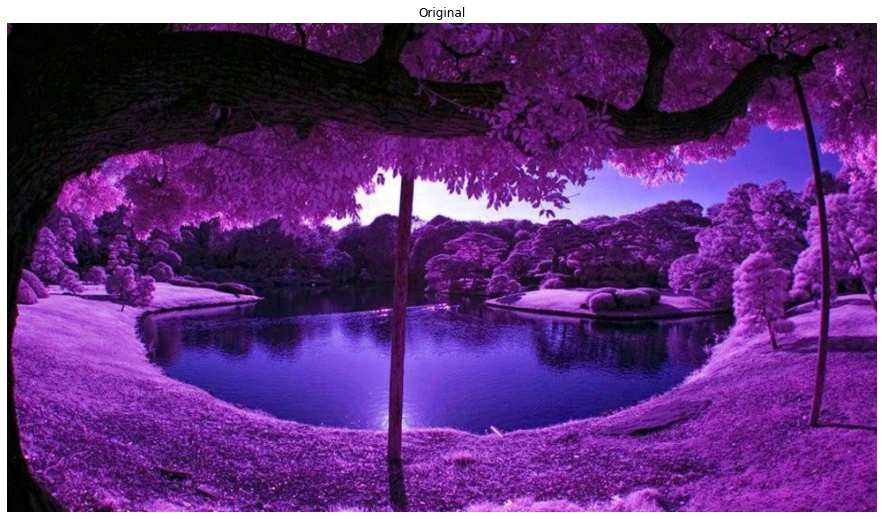

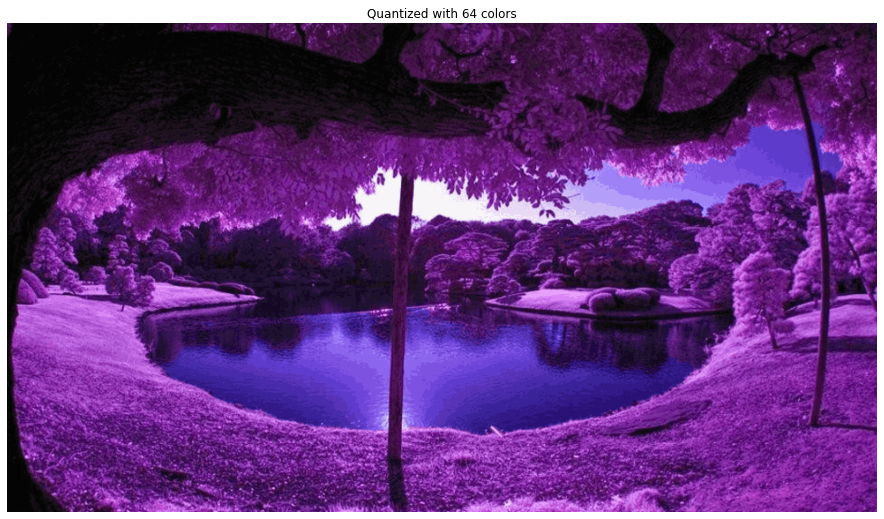

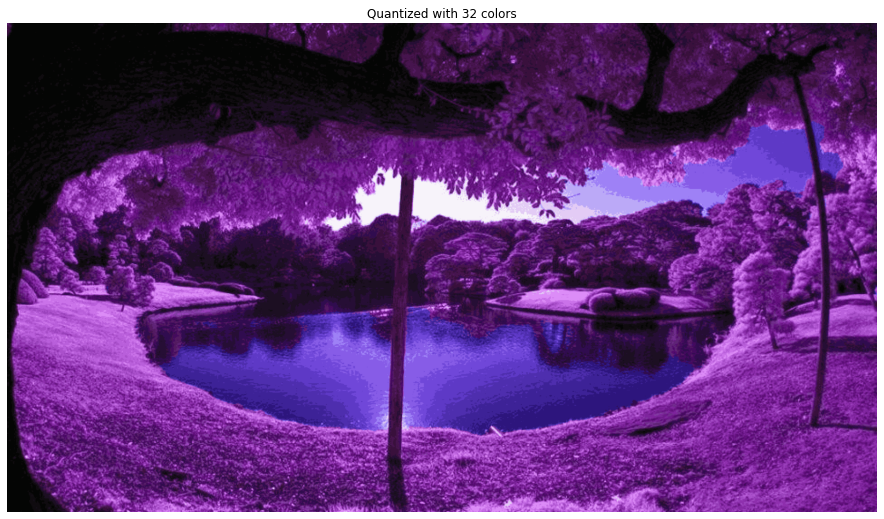

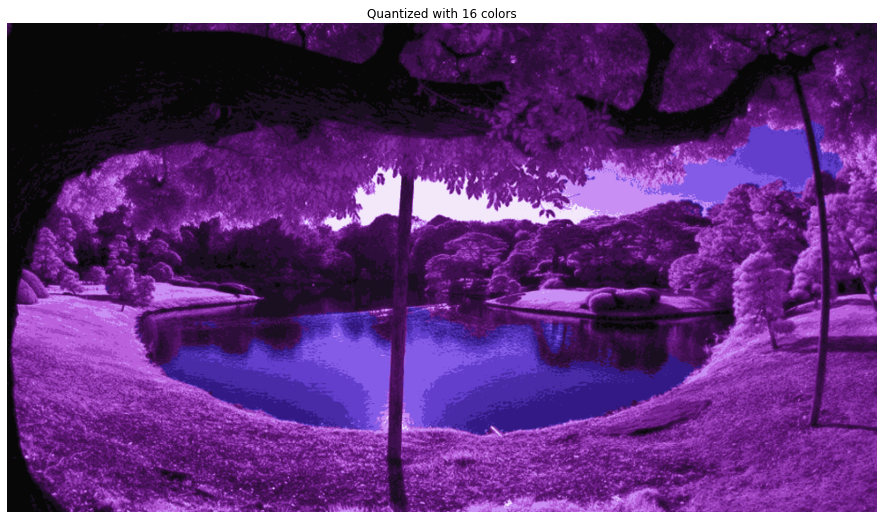

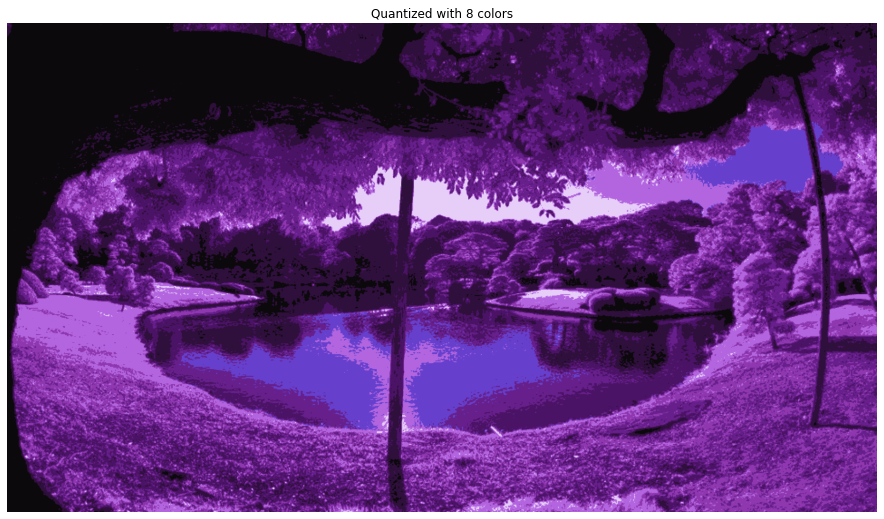

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans

def recreate_image(codebook, labels, w, h):
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

N = [64, 32, 16, 8]
sample = 0.01

img = Image.open('1.jpg')
img = np.array(img, dtype=np.float64) / 255

w, h, ch = img.shape
img_array = np.reshape(img, (w * h, ch))

results = []
for n in N:
    img_sample = img_array[np.random.choice(w * h, int(w * h * sample)), :]
    kmeans = KMeans(n_clusters=n).fit(img_sample)
    results.append(kmeans)
    
plt.figure(figsize=(16, 9))
plt.axis('off')
plt.title('Original')
plt.imshow(img) 

for result in results:
    labels = result.predict(img_array)
    plt.figure(figsize=(16,9))
    plt.axis('off')
    plt.title(f'Quantized with {result.get_params().get("n_clusters")} colors')
    plt.imshow(recreate_image(result.cluster_centers_, labels, w, h))

Silhouette analysis

For n_clusters = 4 The average silhouette_score is : 0.5830422035169395
For n_clusters = 5 The average silhouette_score is : 0.5740089825824137
For n_clusters = 6 The average silhouette_score is : 0.5206045531413668


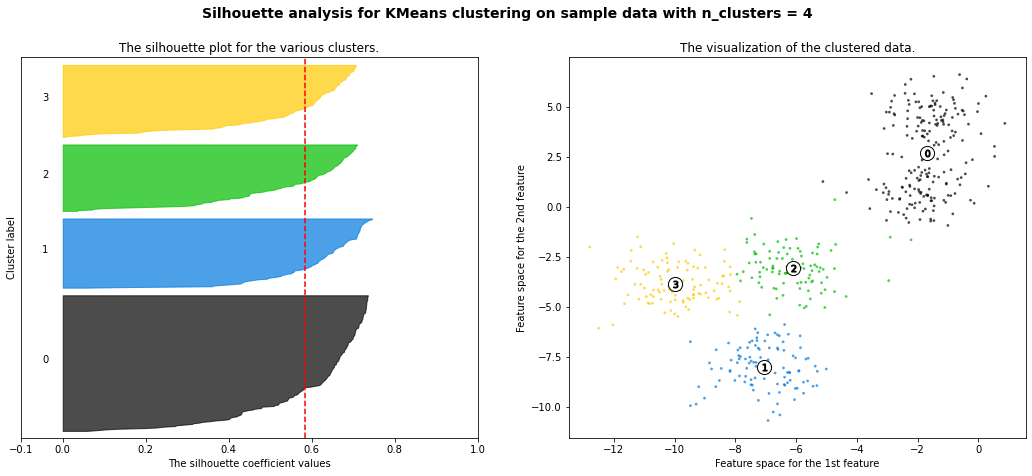

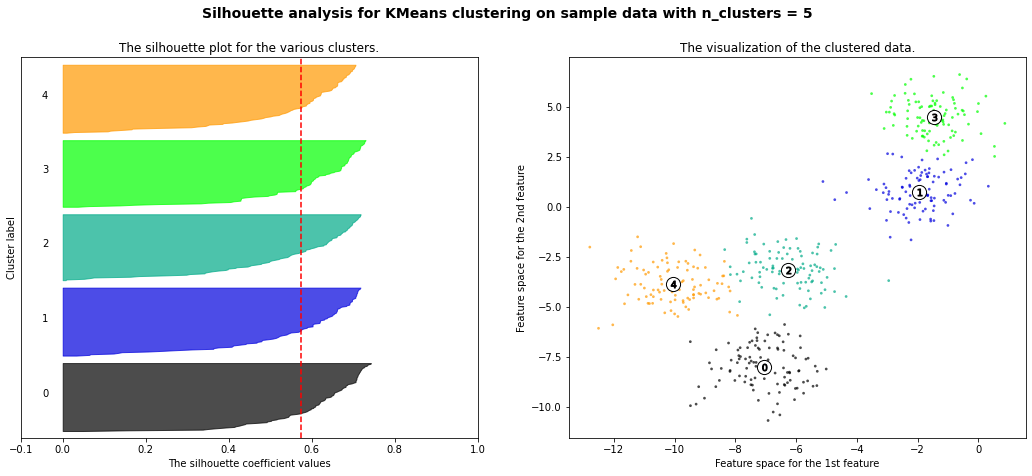

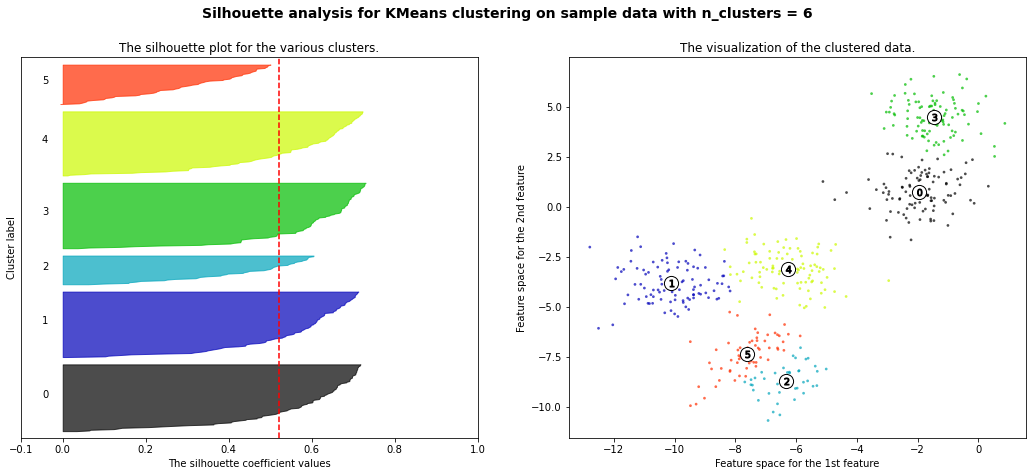

In [5]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=5,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Длинна "The silhouette plot for the various clusters." показывает насколько точки рассматриваемого кластера ближе к точкам этого же кластера чем к точкам другого ближайшего кластера. Ширина показывает размер рассматриваемого кластера.

По графикам видно, что в данных вряд ли 6 кластеров, так как есть кластер со значением коэффициент silhouette меньше среднего.
В варианте с 4 кластерами такой проблемы нет, однако в ней есть кластер, объем которого значительно (в два раза) превышает объемы других. В реальной задаче такое могло возникнуть, если бы данные из этого кластера встречались чаще, чем из других.
В варианте с 5 кластерами все выглядит идеально - нет значений ниже стреднего, кластеры имеют одинаковый объем.
В итоге правдободобными являються оба варианта - с 4 и 5 кластерами.

EM-algorithm

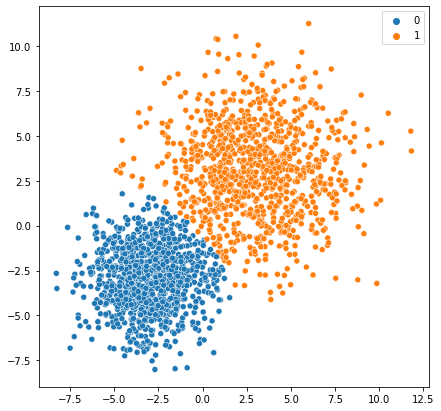

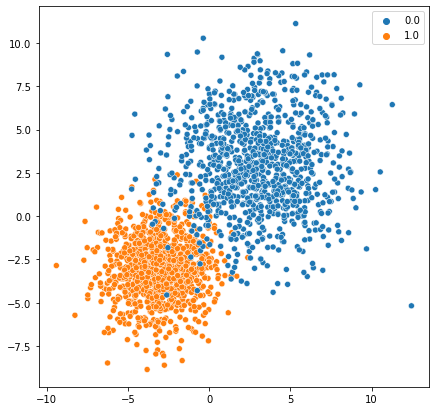

In [6]:
from sklearn.mixture import GaussianMixture
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

mean1 = [-3, -3]
cov1 = [[3, 0],
        [0, 3]]

mean2 = [3, 3]
cov2 = [[7, 0],
        [0, 7]]

x1 = np.random.default_rng().multivariate_normal(mean1, cov1, 1000)
x2 = np.random.default_rng().multivariate_normal(mean2, cov2, 1000)
data = np.vstack([x1,x2])
mixture = GaussianMixture(n_components=2, covariance_type='diag')
labels = mixture.fit_predict(data)

plt.figure(figsize=(7, 7))
sns.scatterplot(x=data[:,0], y=data[:,1], hue=labels)

# Recreating
x1 = np.random.default_rng().multivariate_normal(mixture.means_[0],
                                                 np.diag(mixture.covariances_[0]),
                                                 1000)
x2 = np.random.default_rng().multivariate_normal(mixture.means_[1],
                                                 np.diag(mixture.covariances_[1]),
                                                 1000)
data = np.vstack([x1,x2])

plt.figure(figsize=(7, 7))
sns.scatterplot(x=data[:,0], y=data[:,1], hue=np.hstack([np.ones((1000)),np.zeros((1000))]))

Third task

Natural language processing

<Figure size 2880x2160 with 0 Axes>

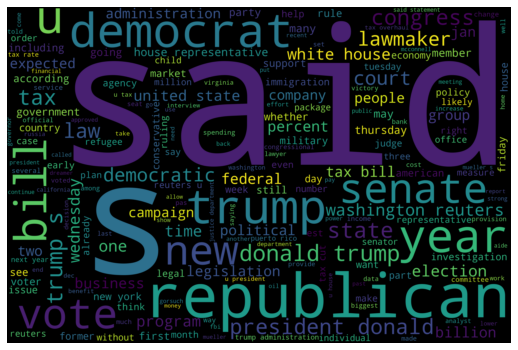

<Figure size 2880x2160 with 0 Axes>

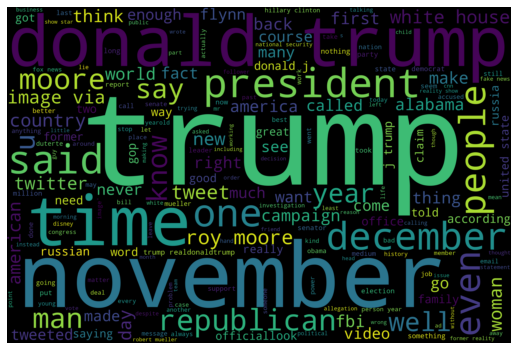

accuracy: 97.5%


In [7]:
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

pd.set_option('max_colwidth', 400)
true = pd.read_csv('True.csv')
fake = pd.read_csv('Fake.csv')

true = true.iloc[0:100, 1:2]
fake = fake.iloc[0:100, 1:2]

true['truth'] = [1 for i in range(true.shape[0])]
fake['truth'] = [0 for i in range(fake.shape[0])]

corpus = pd.concat([true, fake])
#Lowercase and leading/trailing whitespaces
corpus['text'] = corpus['text'].str.lower()
corpus['text'] = corpus['text'].str.strip()
#Remove numbers
corpus['text'] = corpus['text'].str.replace('\d+','', regex=True)
#Removing stop-words
stop_words = stopwords.words('english')
corpus['text'] = corpus['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
#Removing punctuation
table = str.maketrans('', '', string.punctuation)
corpus['text'] = corpus['text'].str.translate(table)
#Lemmatization
lemmatizer = WordNetLemmatizer()
corpus['text'] = corpus['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Visualization
def generate_word_cloud(text):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black').generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    
    plt.figure(figsize=(7, 7))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

generate_word_cloud(corpus[corpus['truth']==1].text.values)
generate_word_cloud(corpus[corpus['truth']==0].text.values)

# Classification
X = TfidfVectorizer(max_features=1000).fit_transform(corpus['text'])
y = corpus['truth']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=666)

model = MultinomialNB().fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))